In [1]:
%pip install matplotlib

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/memtorch_cpu-1.1.6-py3.11-macosx-10.9-universal2.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install qiskit
%pip install pylatexenc

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/memtorch_cpu-1.1.6-py3.11-macosx-10.9-universal2.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/memtorch_cpu-1.1.6-py3.11-macosx-10.9-universal2.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
Note: you may need to restart the kernel to use updated packages.


In [3]:
from qiskit.visualization import plot_bloch_multivector as pbm

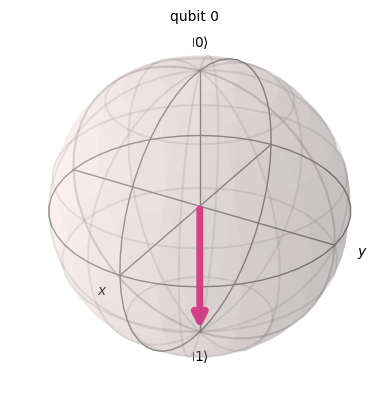

In [4]:
state=[0,1]
pbm(state)

## Quantum Teleportation Code ##
Basic Quantum Teleporation Code using EPR pair between Bob and Alice.
Referenced from Q-munity.com

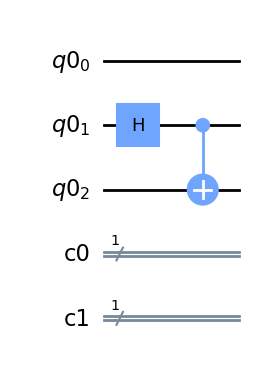

In [5]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import *
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.visualization import plot_histogram

#quantum teleporation using 3 qubits (one is for the quantum bits which Alice-Bob want to share, and others are for EPR pair which is supplied from thrid-party)
#two classical bits are for communicating the measurement results. In our network, these classical bits are handled by router.
qr = QuantumRegister(3)    
cr1 = ClassicalRegister(1)
cr2 = ClassicalRegister(1)
#defining quantum system
teleportation_circuit = QuantumCircuit(qr, cr1, cr2)

def entanglement_bell_pair(qc, a, b):
    
    qc.h(a) # Put qubit a into state |+> or |-> using hadamard gate
    qc.cx(a,b) # CNOT with a as control and b as target

#generating entangled qbuits. Can it be handled from the router?

entanglement_bell_pair(teleportation_circuit, 1, 2) # t
teleportation_circuit.draw(output='mpl')
#q01 and q02 are for EPR pair. Unlike the reference paper, we are open to take care of all cases of EPR pairs.

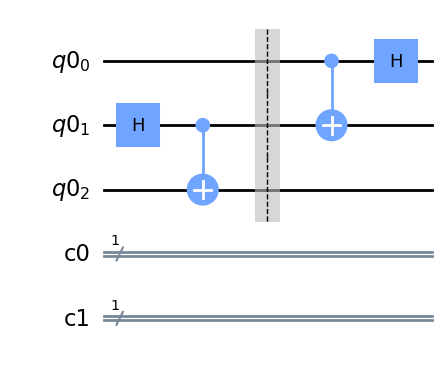

In [6]:
#psi is our target qubit to transfer to Bob.
def alice_state_qubits(qc, psi, a): 
    qc.cx(psi, a) #psi is the state of q0
    qc.h(psi)
    
# call the function to our circuit
teleportation_circuit.barrier() # draw  seperate stages on our system
alice_state_qubits(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output='mpl')

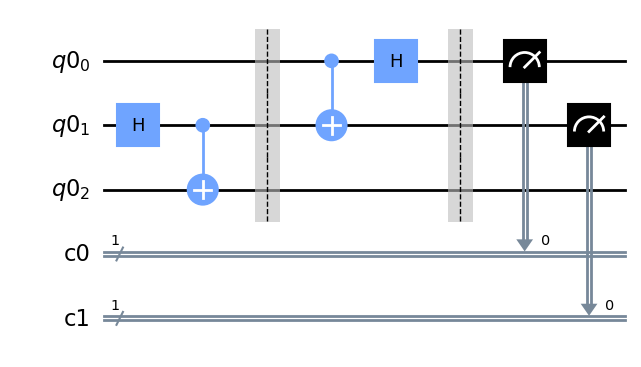

In [7]:
def measure_classical_send(qc, a, b):
    
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

measure_classical_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw(output='mpl')

It's done for Alice's part. Now, based on the measured information from Alice, Bob will apply appropriate quantum gates.


![image](figurebob.png)

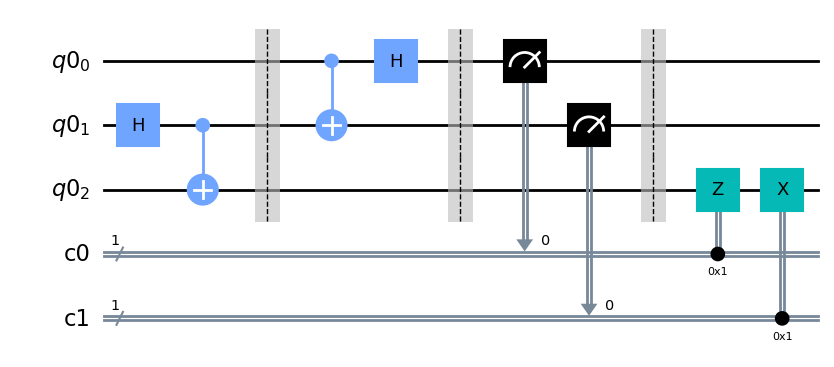

In [8]:
#based on cr1 and cr2 which store the classical bits
def bob_apply_gates(qc, qubit, cr1, cr2):

    qc.z(qubit).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
    qc.x(qubit).c_if(cr2, 1) #if cr2 is 1 apply x gate, look at table above

# Let's apply this to our circuit:
teleportation_circuit.barrier() # Use barrier to separate steps
bob_apply_gates(teleportation_circuit, 2, cr1, cr2)
teleportation_circuit.draw(output='mpl')

Simulation for random case of $|\psi>$

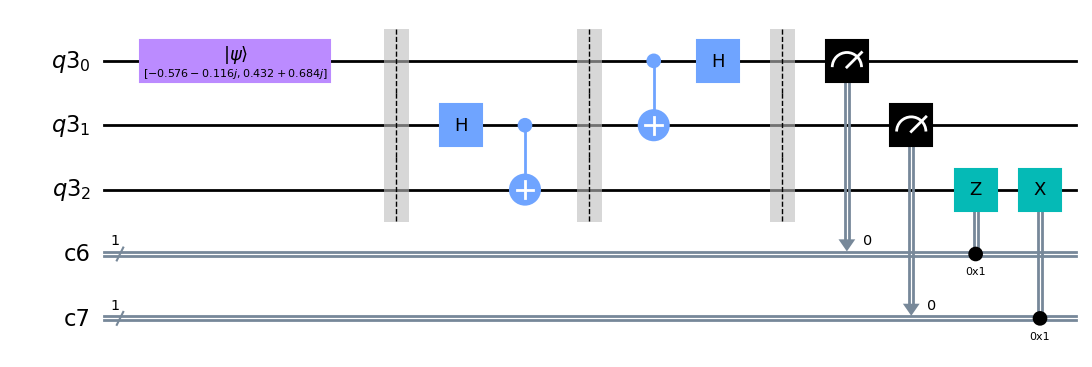

In [11]:
from qiskit.extensions import Initialize

def random_state(nqubits):
    """Creates a random nqubit state vector"""
    from numpy import append, array, sqrt
    from numpy.random import random
    real_parts = array([])
    im_parts = array([])
    for amplitude in range(2**nqubits):
        real_parts = append(real_parts, (random()*2)-1)
        im_parts = append(im_parts, (random()*2)-1)
    # Combine into list of complex numbers:
    amps = real_parts + 1j*im_parts
    # Normalise
    magnitude_squared = 0
    for a in amps:
        magnitude_squared += abs(a)**2
    amps /= sqrt(magnitude_squared)
    return amps
# specify a random state

psi = random_state(1)
init_gate = Initialize(psi)


#Put everything
qr = QuantumRegister(3)   
cr1 = ClassicalRegister(1) 
cr2 = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr1, cr2)

#let's initialise Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# teleportation protocol
entanglement_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_state_qubits(qc, 0, 1)

# alice sends to Bob
measure_classical_send(qc, 0, 1)

# Bob decodes qubits
bob_apply_gates(qc, 2, cr1, cr2)

qc.draw(output='mpl')



## Excute on Backend (From Q-munity) ##


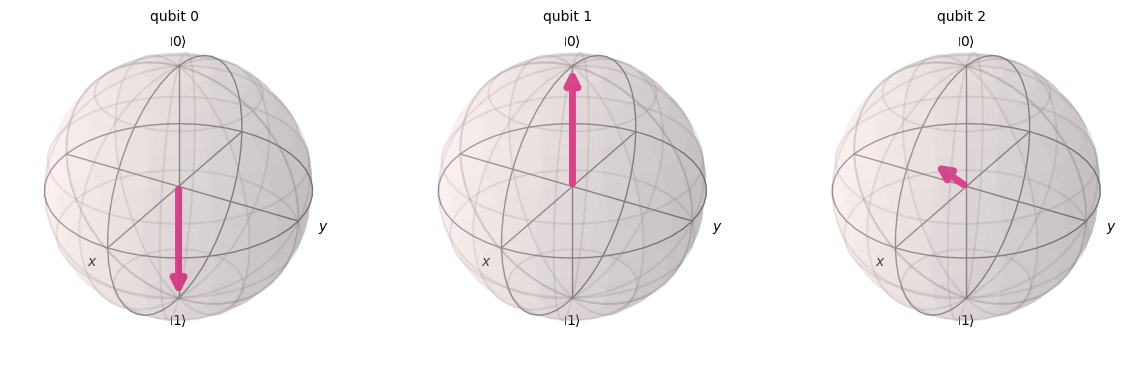

In [12]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

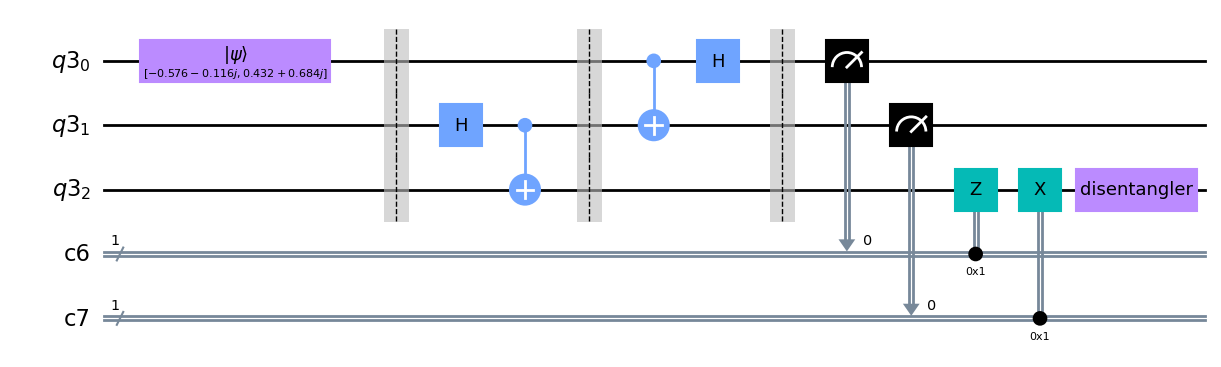

In [13]:
inverse_init_gate = init_gate.gates_to_uncompute()
qc.append(inverse_init_gate, [2])
qc.draw(output='mpl')

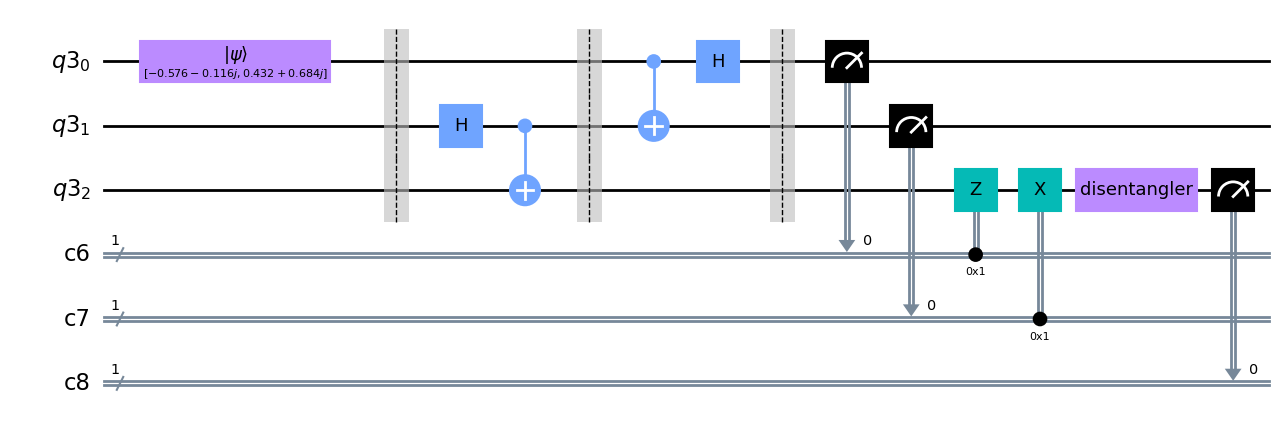

In [14]:
#add a new classical register to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw(output='mpl')

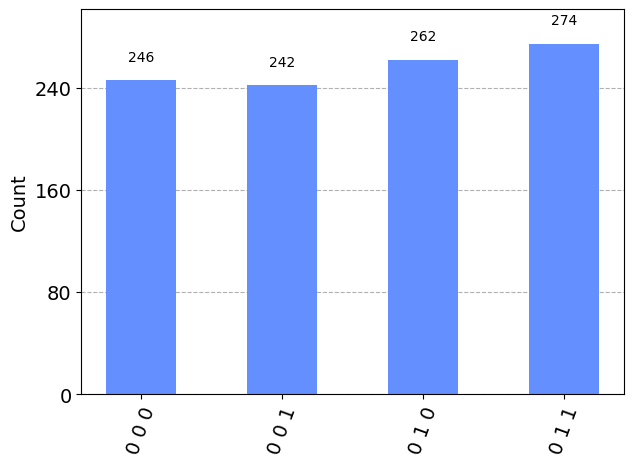

In [15]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

Above plot should be closed to 0.25% 0.25% 0.25% 0.25%

In [3]:
import numpy as np
from qiskit.extensions import Initialize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import array_to_latex
from IPython.display import display, Math, Latex
import sys

information_global = QuantumRegister(1)
EPR_global_sender = QuantumRegister(1)
EPR_global_receiver = QuantumRegister(1)
def random_state(nqubits):
    """Creates a random nqubit state vector"""
    from numpy import append, array, sqrt
    from numpy.random import random
    real_parts = array([])
    im_parts = array([])
    for amplitude in range(2**nqubits):
        real_parts = append(real_parts, (random()*2)-1)
        im_parts = append(im_parts, (random()*2)-1)
    # Combine into list of complex numbers:
    amps = real_parts + 1j*im_parts
    # Normalise
    magnitude_squared = 0
    for a in amps:
        magnitude_squared += abs(a)**2
    amps /= sqrt(magnitude_squared)
    return amps
psi  = random_state(1)
informationbit = Initialize(psi)
print("generated information is : ")
print(informationbit)

def QuantumTeleportation(informationbit):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    qr = QuantumRegister(3)    
    cr1 = ClassicalRegister(1)
    cr2 = ClassicalRegister(1)  
    teleportation_circuit = QuantumCircuit(qr, cr1, cr2)
    teleportation_circuit.append(informationbit,[0])
    teleportation_circuit.barrier
    teleportation_circuit.h(1)
    teleportation_circuit.cx(1,2)
    teleportation_circuit.barrier()
    teleportation_circuit.cx(0,1)
    teleportation_circuit.h(0)
    teleportation_circuit.barrier()
    teleportation_circuit.measure(0,cr1)
    teleportation_circuit.measure(1,cr2)
    #windows ->send classical measuremnts and receive outcome.)
    #bleow code should be interactive with the actual classical network.
    teleportation_circuit.z(qr[2]).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
    teleportation_circuit.x(qr[2]).c_if(cr2, 1) #if cr2 is 1 apply x gate, look at table above
    print(teleportation_circuit)    
    result = execute(teleportation_circuit, backend=statevector_simulator, shots=1).result().get_statevector()
    plot_bloch_multivector(result)

QuantumTeleportation(informationbit)

generated information is : 
Instruction(name='initialize', num_qubits=1, num_clbits=0, params=[(0.27149316763628517-0.84293779072803j), (0.21926783498470379-0.40947400092128516j)])
       ┌───────────────────────────────────────────────┐      ░      ┌───┐ ░ »
q17_0: ┤ Initialize(0.27149-0.84294j,0.21927-0.40947j) ├──────░───■──┤ H ├─░─»
       └─────────────────────┬───┬─────────────────────┘      ░ ┌─┴─┐└───┘ ░ »
q17_1: ──────────────────────┤ H ├────────────────────────■───░─┤ X ├──────░─»
                             └───┘                      ┌─┴─┐ ░ └───┘      ░ »
q17_2: ─────────────────────────────────────────────────┤ X ├─░────────────░─»
                                                        └───┘ ░            ░ »
 c2: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
 c3: 1/══════════════════════════════════════════════════════════════════════»
                             

NameError: name 'plot_bloch_multivector' is not defined